# Predicting diffusive size factors of a rock sample
This tutorial demonstrates how to use PoreSpy's `diffusive_size_factor_AI` and `diffusive_size_factor_DNS` functions to examine the application of the AI-based size factor model on a real rock sample. Due to the computational cost of the DNS method, only a subsection of the image is used in this examples. However, the method can be applied similarly on the entir image of the rock sample.

**For this specific sample:** 

Binary image data was obtained from the digital rock portals for Leopard rock [sample](https://www.digitalrocksportal.org/projects/317/origin_data/1380/) with Voxel length of 2.25 um.

## Import libaries and the AI model path

In [1]:
import subprocess
import os
import numpy as np
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import time
import tensorflow as tf
ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")

Ensure the existence of model path, and create one if non-existant:

In [2]:
if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib

Cloning into 'sf-model-lib'...
Updating files:  87% (7/8)
Updating files: 100% (8/8)
Updating files: 100% (8/8), done.


In the cell below we import the proper library and assign the weights:

In [3]:
h5tools = importlib.import_module("sf-model-lib.h5tools")
DIR_WEIGHTS = "sf-model-lib/diffusion"
fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]

#Identifying hdf5 files and merging them together, the result would be a unique file
h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

Next, we import folder path are related libraries (these chould be installed before usage) and define the AI path for
the training data the wieghts. The training data is used in the backend of the `diffusive_size_factor_AI` to rescale the predictions:

In [4]:
path_AI = "./sf-model-lib/diffusion"
path_train = os.path.join(path_AI, 'g_train_original.hdf5')
path_weights = os.path.join(path_AI, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]

## Reading image of the rock sample

As the image of the rock smaple was large, only a subsection of the image is used in this tutorial for rapid demonstration purposes. We saved a subsection of the Leopard rock sample image of size $100^3$ in PoreSpy's `test/fixtures` folder, which is used for this tutorial. However, the steps to download, read, and slice the rock sample image are provided as markdown cells in the next section for reference.

In [5]:
voxel_size = 2.25e-6
with open('../../../test/fixtures/image_Leopard_slice100.npy', 'rb') as f:
    im = np.load(f)

## Additional info: steps to create a subsection of the rock sample

1) Downloading the image of the rock sample: The cell below creates and ensures the existence of the specific sample path (here rock sample Leopard folder).
The image of the sample can be downloaded through a link as of the cell below "url" and calling `download_image` function, or added seperately as a file to the rock sample folder. If the file is downloaded separately, the last line of the cell should be commented to prevent re-download.

**Note:** 
The downloadable link for a binary image in the digital rocks portal can be found by selecting action
button next to the binary image, selecting download, right click on the download and copy the link. Please note due to the large size of the image the downloading may take a few minutes. 

```python
path = 'rock_sample_Leopard' # this is the path folder for reading/saving the image data for this example
name = 'image_Leopard.raw' # this is the name of the saved file
if not os.path.isdir(path):
    os.makedirs(path)

file_name = path+'/'+name
url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/'

def download_image(filename, url):
    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return

download_image(file_name, url)
```


2) Reading the image as numpy array:
After importing the input image, we need to define the dimensions of the sample, this information is usually gathered from the source of the image. Here, a rock sample of size [1000,1000,1000] was used. Next step is to convert the image data to numpy arrays to be compatible with PoreSpy's input image type for `diffusive_size_factor_AI` and `diffusive_size_factor_DNS`. Here, numpy.fromfile was used to read the image. More details on this function can be found [here](https://numpy.org/doc/1.21/reference/generated/numpy.fromfile.html#:~:text=numpy.fromfile%20%C2%B6%20numpy.fromfile%28file%2C%20dtype%3Dfloat%2C%20count%3D-%201%2C%20sep%3D%27%27%2C%20offset%3D0%2C,as%20well%20as%20parsing%20simply%20formatted%20text%20files)

```python
voxelsx = 1000
voxelsy = 1000
voxelsz = 1000
voxel_size = 2.25e-6

im = np.fromfile(file_name, dtype="<i1")
im = np.reshape(im, (voxelsx,voxelsy,voxelsz))

# pore space must be labeled as True and solid phase as False
pore_space = im == 0 # sometimes this may be 255 or some other value depending on the source of the image
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))
```

**Note:** The line `(ps.metrics.porosity(im))` is to check the porosity level to the information from the input source description. If there is a significant difference, the labels of the input image may need to be reveresd. e.g. you may need to switch False and True in the code above or replace 0 with a different value. You can check the current values in the loaded image using np.unique(im).

3) Slicing the image: In this stage we slice the image to a smaller subsection. This is to speed up the process of prediction with the AI approach and the DNS approach.

```python
im = im[:100,:100,:100]
```

## Segmentation of the image
`Snow2` function is part of the PoreSpy's opensource package, which extracts the pore network and conns from the image.
We then extract the pore network of the porous medium image using PoreSpy's snow2 algorithm. snow2 returns the segmented image of the porous medium as well as extracted network data.

In [6]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
conns = net['throat.conns']

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/73 [00:00<?, ?it/s]

## Size factor prediction

Create the AI model and load the weights:

In [7]:
model = ps.networks.create_model()
# Giving the path weights to .load function
model.load_weights(path_weights)

[16:07:44] WARNING  `lr` is deprecated in Keras optimizer, please use `learning_rate` or use the   ]8;id=736255;file://C:\Users\jeff\anaconda3\envs\dev\lib\site-packages\keras\src\optimizers\optimizer.py\optimizer.py]8;;\:]8;id=382237;file://C:\Users\jeff\anaconda3\envs\dev\lib\site-packages\keras\src\optimizers\optimizer.py#123\123]8;;\
                    legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.                                        

Now that we have the regions, model and image data, we can use it for prediction. Finally we intiate the AI prediction process:


In [8]:
predicted_ai = ps.networks.diffusive_size_factor_AI(
    regions,
    model=model,
    g_train=g_train,
    throat_conns=conns,
    voxel_size = voxel_size
)

Preparing images tensor:   0%|          | 0/122 [00:00<?, ?it/s]

8/8 [==============================] - 14s 2s/step


Similarly we run the DNS(Direct Numerical Simulation) **Note:** This cell is often the longest to exute. Here for comparison purposes, we used `time` to calculate the runtime of this cell.

In [9]:
startTime = time.time()
predicted_dns = ps.networks.diffusive_size_factor_DNS(regions,
                                                    throat_conns=conns,
                                                         voxel_size = voxel_size)
executionTime_dns = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime_dns))

Preparing images and DNS calculations:   0%|          | 0/122 [00:00<?, ?it/s]

Execution time in seconds: 53.7852041721344


**Note:** 
Once the values are predicted, you can save them ih hdf5 format for later use. 

Finally we plot the Comparison between AI results and DNS predicted results. This helps us to understand the deviation between the two and also mesaure the accuracy and the correctness of the results:

Text(0, 0.5, 'DNS_based size factor values')

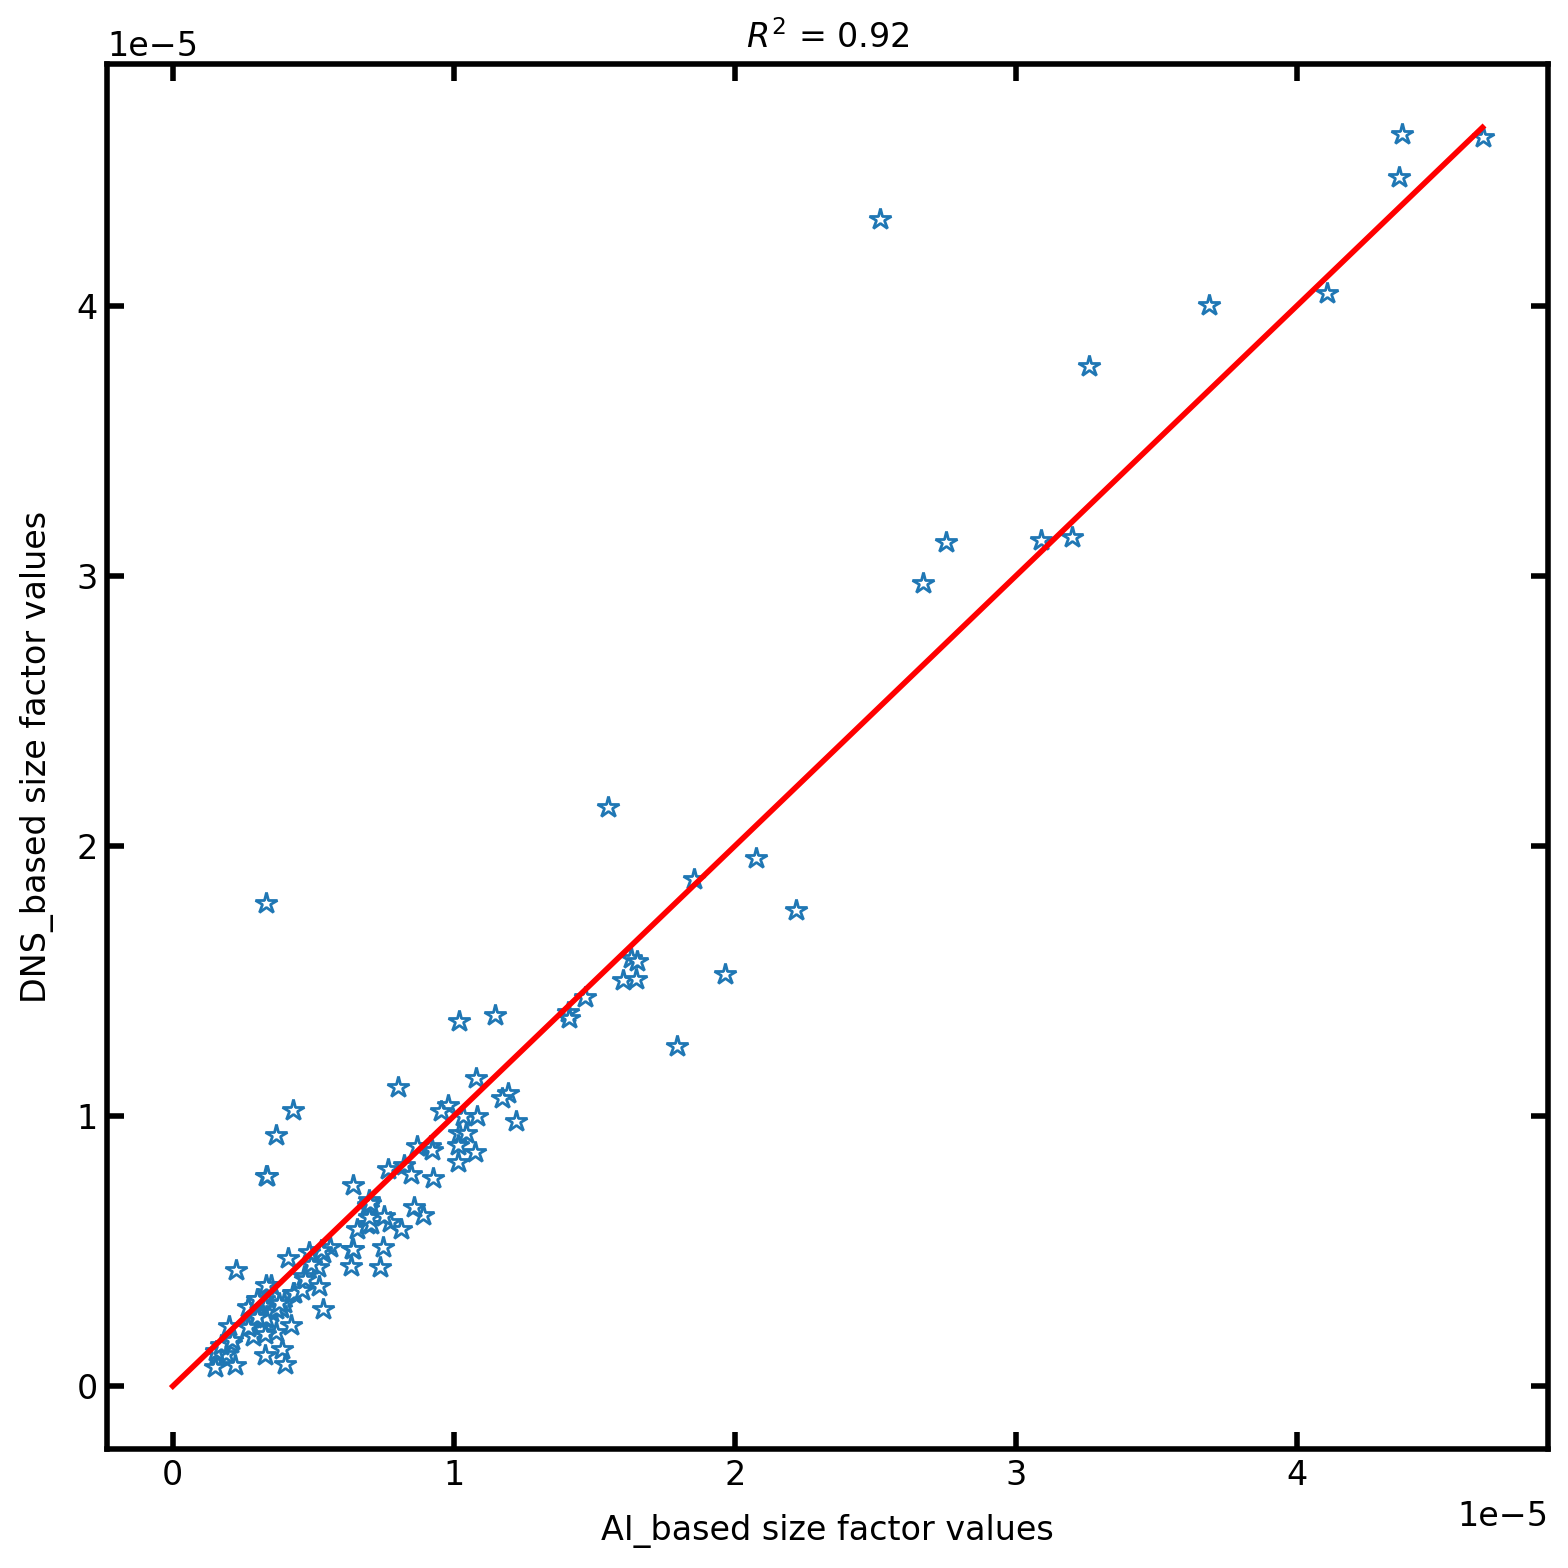

In [10]:
max_val = np.max([predicted_ai, predicted_dns])
plt.figure(figsize=[8,8])
plt.plot(predicted_ai, predicted_dns, '*', [0, max_val], [0, max_val], 'r')
plt.title(r'$R^2$ = ' + str(np.round(r2_score(predicted_dns, predicted_ai), 2)));
plt.xlabel('AI_based size factor values')
plt.ylabel('DNS_based size factor values')